### Import Packages

In [1]:
!pip install sentence_transformers
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn import metrics, manifold, preprocessing, model_selection, naive_bayes, linear_model, svm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
import joblib
import random
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.4 MB/s 
     |████████████████████████████████| 4.7 MB 36.3 MB/s 
     |████████████████████████████████| 1.3 MB 24.1 MB/s 
     |████████████████████████████████| 101 kB 5.3 MB/s 
     |████████████████████████████████| 596 kB 30.1 MB/s 
     |████████████████████████████████| 6.6 MB 58.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=29e37c3b86421fd62f62b799bf770acb972a6839de5efcd37e655ce731c4c718
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Setup Dataframes

In [2]:
#read the training dataset into a dataframe
df = pd.read_csv('BBC News Train.csv')
df = df[['Text', 'Category']]
df = df.rename(columns = {'Text' : 'text', 'Category' : 'label'})
df['label'].value_counts()

sport            493
business         483
politics         421
entertainment    420
tech             408
Name: label, dtype: int64

### Embedding

In [3]:
#account for class imbalance by taking the number of labels in the training dataset
sport = df[df['label'] == 'sport']
business = df[df['label'] == 'business']
politics = df[df['label'] == 'politics']
entertainment = df[df['label'] == 'entertainment']
tech = df[df['label'] == 'tech']

len_sport = len(sport['label'])
len_business = len(business['label'])
len_politics = len(politics['label'])
len_entertainment = len(entertainment['label'])
len_tech = len(tech['label'])

lenlst = [len_sport, len_business, len_politics, len_entertainment, len_tech]
mini = min(lenlst)

In [4]:
#downsample each label based on the minimum length of labels
sport_downsample = resample(sport,
             replace=True,
             n_samples=mini,
             random_state=42)
business_downsample = resample(business,
             replace=True,
             n_samples=mini,
             random_state=42)
politics_downsample = resample(politics,
             replace=True,
             n_samples=mini,
             random_state=42)
entertainment_downsample = resample(entertainment,
             replace=True,
             n_samples=mini,
             random_state=42)
tech_downsample = resample(tech,
             replace=True,
             n_samples=mini,
             random_state=42)

dff = pd.concat([sport_downsample, business_downsample, politics_downsample, entertainment_downsample, tech_downsample])
dff['label'].value_counts()

sport            408
business         408
politics         408
entertainment    408
tech             408
Name: label, dtype: int64

In [5]:
#fit tokenizer on the phrases to get word index
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 120
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values.tolist())
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 29726 unique tokens.


In [6]:
#convert the phrases in the training dataset to their index form by using the tokenizer
X = tokenizer.texts_to_sequences(dff['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of text/phrase tensor:', X.shape)

Shape of text/phrase tensor: (2040, 500)


In [7]:
#encode the parent class label
Y = pd.get_dummies(dff['label']).values
print('Shape of parent label tensor:', Y.shape)

Shape of parent label tensor: (2040, 5)


In [8]:
#split the train and test data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1836, 500) (1836, 5)
(204, 500) (204, 5)


### LSTM Model Building & Evaluation

In [9]:
#build the bi-directional LSTM model
model = Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.Bidirectional(layers.LSTM(120, dropout = 0.3)))
model.add(layers.Dense(120, activation = "relu"))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 120)          6000000   
                                                                 
 bidirectional (Bidirectiona  (None, 240)              231360    
 l)                                                              
                                                                 
 dense (Dense)               (None, 120)               28920     
                                                                 
 dense_1 (Dense)             (None, 5)                 605       
                                                                 
Total params: 6,260,885
Trainable params: 6,260,885
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
#fit the model on the X_train and Y_train
epochs = 100
batch_size = 64
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_test, Y_test), validation_split = 0.10)
# history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/100
26/26 [==============================] - 20s 136ms/step - loss: 1.5973 - accuracy: 0.2627 - auc: 0.5694 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.5853 - val_accuracy: 0.1685 - val_auc: 0.5722 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
26/26 [==============================] - 2s 82ms/step - loss: 1.5649 - accuracy: 0.4219 - auc: 0.7264 - precision: 0.3558 - recall: 0.0224 - val_loss: 1.4103 - val_accuracy: 0.4728 - val_auc: 0.7849 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
26/26 [==============================] - 2s 66ms/step - loss: 1.0753 - accuracy: 0.6525 - auc: 0.8904 - precision: 0.8758 - recall: 0.2391 - val_loss: 0.9534 - val_accuracy: 0.7120 - val_auc: 0.9023 - val_precision: 0.8780 - val_recall: 0.3913
Epoch 4/100
26/26 [==============================] - 2s 65ms/step - loss: 0.4542 - accuracy: 0.8910 - auc: 0.9780 - precision: 0.9345 - recall: 0.7863 - val_loss: 0.7953 - val_accuracy: 0.7609 - val_auc: 0.

In [11]:
#evaluate model on test data
accr = model.evaluate(X_test,Y_test)

7/7 [==============================] - 0s 19ms/step - loss: 1.2499 - accuracy: 0.7745 - auc: 0.9200 - precision: 0.7879 - recall: 0.7647


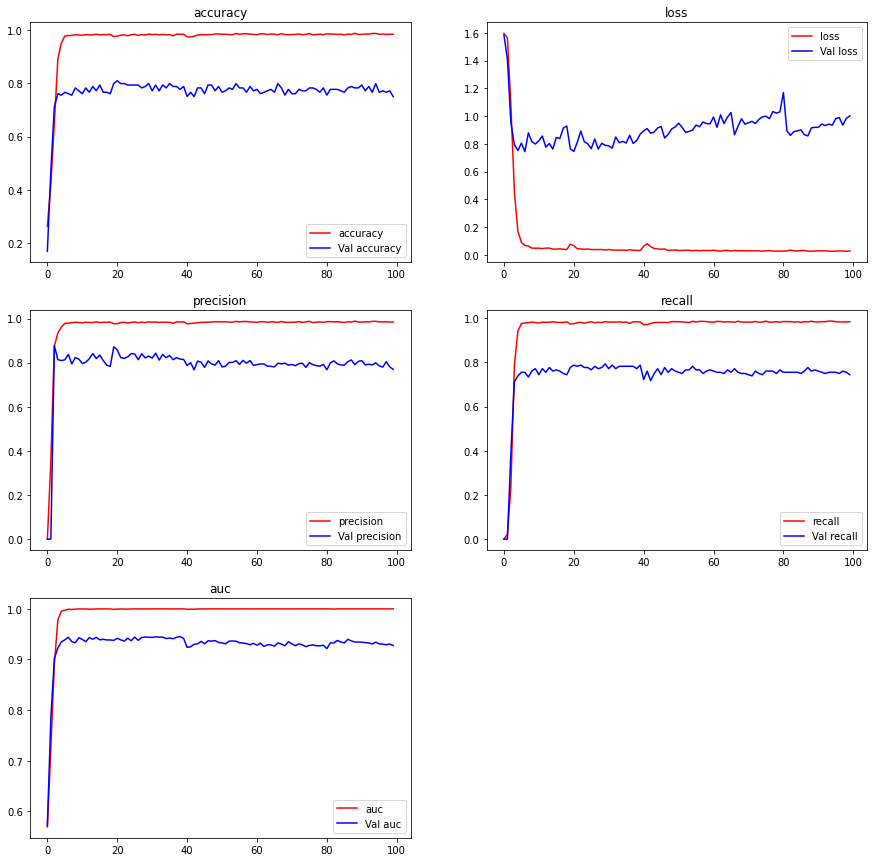

In [12]:
#plot:                         
#1. train accuracy vs val accuracy
#2. train loss vs val loss
#3. train precision vs val precision
#4. train recall vs val recall
#5. train auc vs val auc
plt.figure(figsize = (15, 15))
def plot_metric(history, label, p):
    plt.subplot(3, 2, p)
    plt.plot(history[label], label = label, color = 'red')
    plt.plot(history['val_'+label], label = 'Val ' + label, color = 'blue')
    plt.legend()
    plt.title(label)
plot_metric(history.history, 'accuracy', 1)
plot_metric(history.history, 'loss', 2)
plot_metric(history.history, 'precision', 3)
plot_metric(history.history, 'recall', 4)
plot_metric(history.history, 'auc', 5)
plt.show()